In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
import matplotlib.pyplot as plt

In [29]:
sdf = pd.read_csv('S.csv')
udf = pd.read_csv('U.csv')
bdf = pd.read_csv('BR.csv')
sdf['Сеанси'] = sdf['Сеанси'].astype(int, errors='ignore')
udf['Користувачі'] = udf['Користувачі'].astype(int, errors='ignore')
bdf['Показник відмов'] = bdf['Показник відмов'].str.replace(',', '.').str.rstrip('%').astype('float') / 100.0

df = pd.merge(pd.merge(sdf, udf, on= ['Індекс дня']), bdf, on=['Індекс дня'])
df.drop(df.tail(1).index, inplace=True)
df

,Індекс дня,Сеанси,Користувачі,Показник відмов
0,01.01.21,1181,1118,0.5783
1,02.01.21,1430,1340,0.5944
2,03.01.21,1440,1329,0.5549
3,04.01.21,1865,1739,0.5357
4,05.01.21,2615,2422,0.5193
...,...,...,...,...
360,27.12.21,1627,1500,0.4899
361,28.12.21,2114,1924,0.4423
362,29.12.21,2056,1848,0.4494
363,30.12.21,1661,1553,0.4335


In [30]:
def plot_anomalies(df, method, columns, title, colors):
    anomalies = df[df[method] == -1] if method != 'Z_Score' else df[df[method] == 1]

    plt.figure(figsize=(10, 6))
    for column in columns:
        plt.plot(df['Індекс дня'], df[column], label=column, color=colors[column])
        plt.scatter(anomalies['Індекс дня'], anomalies[column], label=f'{column} Anomalies', color='k')
    
    plt.title(f'{title} - Method: ({method})')
    plt.xlabel('Індекс дня')
    plt.ylabel('Значення')
    plt.legend()
    plt.show()

colors = {'Сеанси': 'm', 'Користувачі': 'y', 'Показник відмов': 'c'}

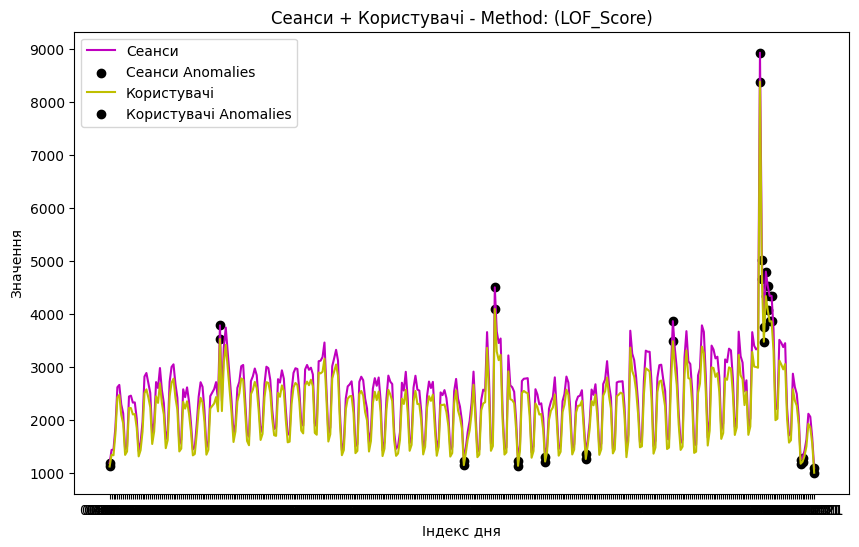

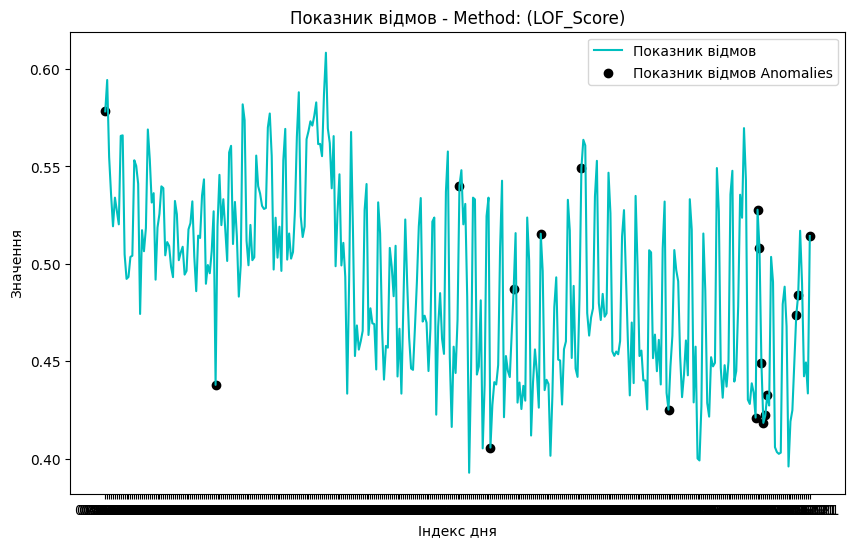

In [33]:
def detect_lof(data, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    data['LOF_Score'] = lof.fit_predict(data[['Сеанси', 'Користувачі', 'Показник відмов']])
    return data

df = detect_lof(df)
plot_anomalies(df, 'LOF_Score', ['Сеанси', 'Користувачі'], 'Сеанси + Користувачі', colors)
plot_anomalies(df, 'LOF_Score', ['Показник відмов'], 'Показник відмов', colors)

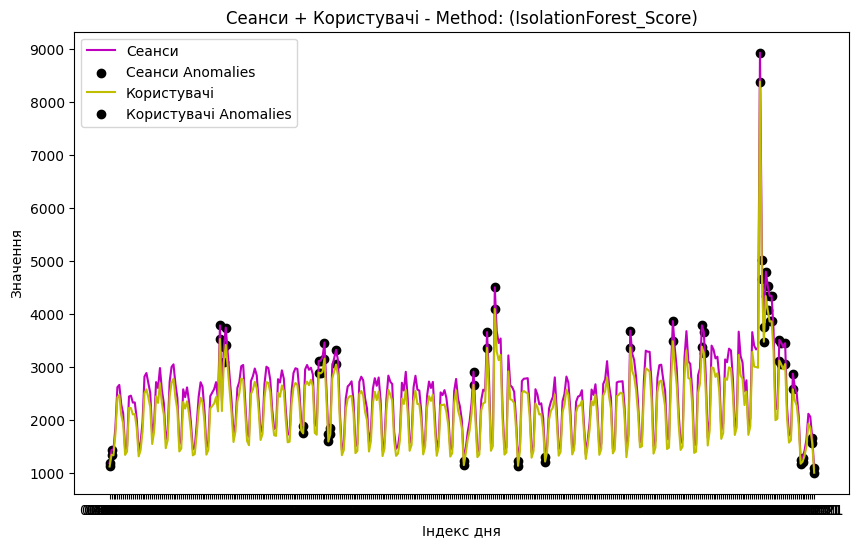

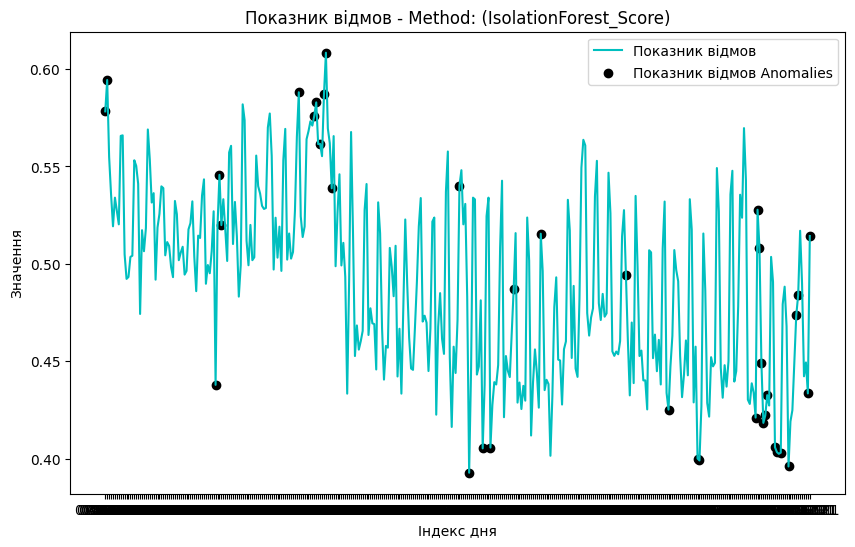

In [34]:
def detect_isolation_forest(data, contamination=0.1):
    iso_forest = IsolationForest(contamination=contamination)
    data['IsolationForest_Score'] = iso_forest.fit_predict(data[['Сеанси', 'Користувачі', 'Показник відмов']])
    return data

df = detect_isolation_forest(df)
plot_anomalies(df, 'IsolationForest_Score', ['Сеанси', 'Користувачі'], 'Сеанси + Користувачі', colors)
plot_anomalies(df, 'IsolationForest_Score', ['Показник відмов'], 'Показник відмов', colors)


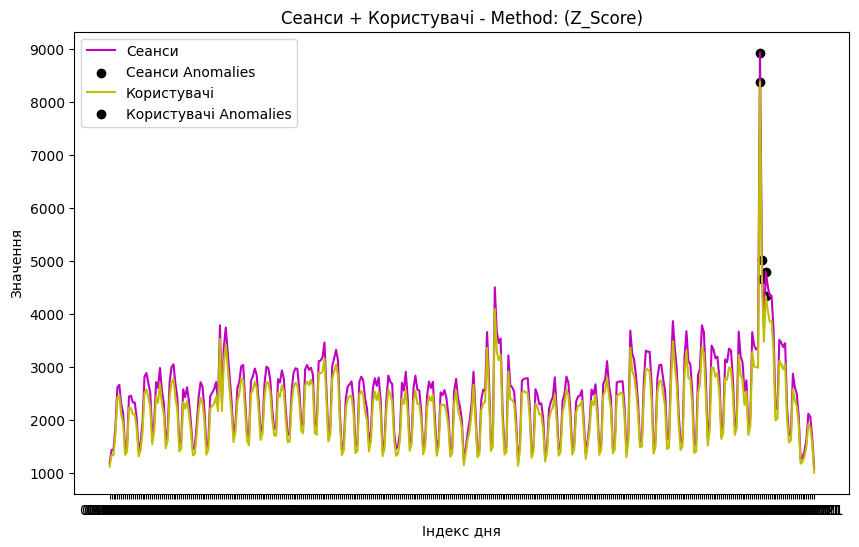

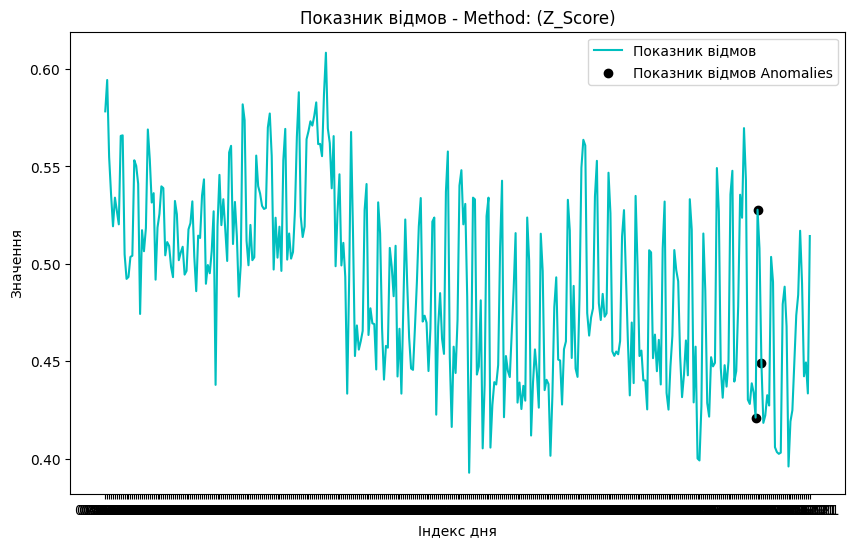

In [35]:
def detect_z_score(data, threshold=3):
    z_scores = np.abs(stats.zscore(data[['Сеанси', 'Користувачі', 'Показник відмов']]))
    data['Z_Score'] = (z_scores > threshold).any(axis=1).astype(int)
    return data

df = detect_z_score(df)
plot_anomalies(df, 'Z_Score', ['Сеанси', 'Користувачі'], 'Сеанси + Користувачі', colors)
plot_anomalies(df, 'Z_Score', ['Показник відмов'], 'Показник відмов', colors)

In [36]:
df.to_csv('anomaly_detected_data.csv', index=False)